# IDS - analysis

In [8]:
%run ../rule_miner.py
%run ../rules.py
%run ../IDS_smooth_local.py

%run C:/code/python/CBA/main.py

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import copy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyarc import TransactionDB
from pyarc.algorithms import (
    top_rules,
    createCARs,
    M1Algorithm
)
from pyarc import CBA, TransactionDB

import scipy.stats as stats

import random

plt.style.use("ggplot")

# Prediction of new cases

Na základě f1 skóre.

In [10]:
dummy_label = "N/A"

def predict(soln_set, list_rules, df, Y, new_Y):
   
    y_pred_dict = {}
    for index in soln_set:
        rule = list_rules[index]

        y_pred_per_rule = list(rule.get_y_pred_per_rule(df, Y))

        rule_f1_score = f1_score(Y, y_pred_per_rule, average='micro')
        y_pred_dict.update({rule_f1_score: y_pred_per_rule})
        

    y_pred = []
    top_f1_score = sorted(y_pred_dict.keys(), reverse=True)[0]

    
    
    for subscript in range(len(Y)):
        v_list = []
        for k, v in y_pred_dict.items():
            v_list.append(v[subscript])
        set_v_list = set(v_list)
       
       
        if len(list(set_v_list)) - 1 >  len(set(Y)): # "and for data points that satisfy more than one itemset, we predict using the rule with the highest F1 score on the training data."
            y_pred.append(y_pred_dict[top_f1_score][subscript])
        else:                                          # unique
            y_pred.append(list(set(v_list))[0])
        
        
  
   
    return y_pred

# Default rule

Je zde několik možností

* majoritní třída v datech
* majoritní třída v datech po odstranění "klasifikovatelných" instancí


In [11]:
def default_class(soln_set, list_of_rules, df, Y, new_Y, method="major_class"):
    if method == "major_class":
        mode = list(Y.mode())
        
        return random.sample(mode, 1)[0]
        
    if method == "major_class_remaining":
        pred = predict(soln_set, list_of_rules, df, Y, new_Y)
        
        indexes = np.arange(len(pred))[np.array(pred) == dummy_label]
        
        mode = list(Y[indexes].mode())
        
        return random.sample(mode, 1)[0]

# Modified code

In [12]:
# smooth local search algorithm which returns a solution set
def smooth_local_search_modified(list_rules, df, Y, lambda_array, delta, delta_prime):
    # step by step implementation of smooth local search algorithm in the 
    # FOCS paper: https://people.csail.mit.edu/mirrokni/focs07.pdf (page 6)
    
    # step 1: set the value n and OPT; initialize soln_set to empty
    n = len(list_rules)
    OPT = compute_OPT(list_rules, df, Y, lambda_array, n)

    print("2/n*n OPT value is "+str(2.0/(n*n)*OPT))
    
    soln_set = set()
    
    restart_omega_computations = False
    
    while(True):
    
        # step 2 & 3: for each element estimate omega within certain error_threshold; if estimated omega > 2/n^2 * OPT, then add 
        # the corresponding rule to soln set and recompute omega estimates again
        omega_estimates = []
        for rule_x_index in range(n):
                
            print("Estimating omega for rule "+str(rule_x_index))
            omega_est = estimate_omega_for_element(soln_set, delta, rule_x_index, list_rules, df, Y, lambda_array, 1.0/(n*n) * OPT, n)
            omega_estimates.append(omega_est)
            #print("Omega estimate is "+str(omega_est))
            
            if rule_x_index in soln_set:
                continue
            
            if omega_est > 2.0/(n*n) * OPT:
                # add this element to solution set and recompute omegas
                soln_set.add(rule_x_index)
                restart_omega_computations = True
                print("-----------------------")
                print("Adding to the solution set rule "+str(rule_x_index))
                print("-----------------------")
                break    
        
        if restart_omega_computations: 
            restart_omega_computations = False
            continue
            
        # reaching this point of code means there is nothing more to add to the solution set, but we can remove elements
        for rule_ind in soln_set:
            if omega_estimates[rule_ind] < -2.0/(n*n) * OPT:
                soln_set.remove(rule_ind)
                restart_omega_computations = True
                
                print("Removing from the solution set rule "+str(rule_ind))
                break
                
        if restart_omega_computations: 
            restart_omega_computations = False
            continue
            
        # reaching here means there is no element to add or remove from the solution set
        return sample_random_set(soln_set, delta_prime, n)

## Objective modification

* $f_1$ - ok
* $f_2$ - zrušit
* $f_{34}$ - kolik pravidla vyhovují instancím, ale problém se submodularitou, viz dole. Ještě třeba upravit
* $f_5$ - ok
* $f_{6}$ - CBA order a počet chyb klasifikátoru - není submodulární. Odříznout pak při stoupání chyb?
* $f_7$ - zrušit


In [13]:
    # f0 term
    def f0(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        f0 = len_list_rules - len(soln_set) # |S| - size(R)

        return f0
    
    
    # f1 term
    def f1(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        Lmax = max_rule_length(list_rules)
        sum_rule_length = 0.0
        for rule_index in soln_set:
            sum_rule_length += list_rules[rule_index].get_length()
    
        f1 = Lmax * len_list_rules - sum_rule_length

        return f1
   
    
   
    # f2 term - intraclass overlap
    def f2(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        
        sum_overlap_intraclass = 0.0
        for r1_index in soln_set:
            for r2_index in soln_set:
                if r1_index >= r2_index:
                    continue
                if list_rules[r1_index].class_label == list_rules[r2_index].class_label:
                    overlap_tmp = list_rules[r1_index].overlaps[list_rules[r2_index]]
                    sum_overlap_intraclass += len(overlap_tmp)
        f2 = df.shape[0] * len_list_rules * len_list_rules - sum_overlap_intraclass

        return f2

        
    # f3 term - interclass overlap
    def f3(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        
        sum_overlap_interclass = 0.0
        for r1_index in soln_set:
            for r2_index in soln_set:
                if r1_index >= r2_index:
                    continue
                if list_rules[r1_index].class_label != list_rules[r2_index].class_label:
                    overlap_tmp = list_rules[r1_index].overlaps[list_rules[r2_index]]
                    sum_overlap_interclass += len(overlap_tmp)
        f3 = df.shape[0] * len_list_rules * len_list_rules - sum_overlap_interclass

        return f3
   
    
    def f_34_modified_simple_sum(soln_set, list_rules, df):
        
        cover = []
        
        for rule in np.array(list_rules)[soln_set]:
            tmp = rule.get_cover(df)
            
            cover.append(len(tmp))
        
        f_34 = sum(cover)
        
        return f_34
    
    
    def f_34_modified_set_intersect(soln_set, list_rules, df):
        
        cover = set()
        
        for rule in np.array(list_rules)[soln_set]:
            tmp = rule.get_cover(df)
            
            for t in tmp:
                cover.add(t)
        
        f_34 = len(cover)
        
        return f_34
    
    
    def f_34_modified_cover_mean(soln_set, list_rules, df):
        
        cover = []
        
        for rule in np.array(list_rules)[soln_set]:
            tmp = rule.get_cover(df)
            
            cover.append(len(tmp))
        
        f_34 = np.mean(cover)
        
        return f_34
        
        
    # f4 term - coverage of all classes
    def f4(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        classes_covered = set() # set
        for index in soln_set:
            classes_covered.add(list_rules[index].class_label)
        f4 = len(classes_covered)

        return f4
        
    # f5 term - accuracy
    def f5(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        sum_incorrect_cover = 0.0
        for index in soln_set:
            sum_incorrect_cover += len(list_rules[index].get_incorrect_cover(df,Y))
        f5 = df.shape[0] * len_list_rules - sum_incorrect_cover

        return f5
    
    
    # f5 - number of classifier errors
    def f5_modified(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        sum_incorrect_cover = 0.0
        for index in soln_set:
            sum_incorrect_cover += len(list_rules[index].get_incorrect_cover(df,Y))
        f5 = df.shape[0] * len_list_rules - sum_incorrect_cover

        return f5
    
    
    #f6 term - cover correctly with at least one rule
    def f6(soln_set, list_rules, df):
        atleast_once_correctly_covered = set()
        for index in soln_set:
            correct_cover, full_cover = list_rules[index].get_correct_cover(df,Y)
            atleast_once_correctly_covered = atleast_once_correctly_covered.union(set(correct_cover))
        f6 = len(atleast_once_correctly_covered)

        return f6
    
    
    

    
    
fs = [f0, f1, f2, f3, f4, f5, f6]

In [14]:
# computes the objective value of a given solution set
def func_evaluation_modified(soln_set, list_rules, df, Y, lambda_array, len_list_rules):
    # evaluate the objective function based on rules in solution set 
    # soln set is a set of indexes which when used to index elements in list_rules point to the exact rules in the solution set
    # compute f1 through f7 and we assume there are 7 lambdas in lambda_array
    f = [] #stores values of f1 through f7; 
    
    # f0 term
    f.append(
        f0(soln_set, list_rules, df) / f0({}, list_rules, df)
    )
    
    
    # f1 term
    f1_empty  = f1({}, list_rules, df)
    
    if f1_empty == 0:
        f.append(0)
    else:
        f.append(
            f1(soln_set, list_rules, df) / f1({}, list_rules, df)
        )
    
    # f2 term - intraclass overlap
    f.append(
        f2(soln_set, list_rules, df) / f2({}, list_rules, df)
    )
    
    # f3 term - interclass overlap
    f.append(
        f3(soln_set, list_rules, df) / f3({}, list_rules, df)
    )
    
    # f4 term - coverage for all classes
    f4_empty  = f4({}, list_rules, df)
    
    if f4_empty == 0:
        f.append(0)
    else:
        f.append(
            f4(soln_set, list_rules, df) / f4({}, list_rules, df)
        )
    
    # f5 term - accuracy
    f.append(
        f5(soln_set, list_rules, df) / f5({}, list_rules, df)
    )

    
    # f6 term - cover correctly with at least one rule
    f6_empty  = f6({}, list_rules, df)
    
    if f6_empty == 0:
        f.append(0)
    else:
        f.append(
            f6(soln_set, list_rules, df) / f6({}, list_rules, df)
        )
    
    obj_val = 0.0
    for i in range(7):
        obj_val += f[i] * lambda_array[i]
    
    #print(obj_val)
    return obj_val

## Parameter initialization and dataset loading

In [15]:
lambda_array = [1.0]*7 

In [16]:
df = pd.read_csv('../data/iris0.csv', ',')
df_raw = df.iloc[:, :-1]
Y = df.iloc[:, -1]

txns_train = TransactionDB.from_DataFrame(df)

rules = run_fim_apriori(df_raw, 0.34)

list_of_rules = createrules(rules, list(set(Y)))
print(len(list_of_rules), "rules created")

prepare_caches(list_of_rules, df, Y)
prepare_overlap(list_of_rules, df)
print("caches prepared")

def optimize(param):
    lambda_array = [1.0]*7     # use separate hyperparamter search routine
    #lambda_array = [1, 0, 0, 1, 0, 0, 0]
    
    s1 = smooth_local_search(list_of_rules, df, Y, lambda_array, 0.33, param)
    func1 = func_evaluation(s1, list_of_rules, df, Y, lambda_array, len(list_of_rules))

    return func1, s1


def optimize_modified(param):
    lambda_array = [1.0]*7     # use separate hyperparamter search routine
    #lambda_array = [1, 0, 0, 1, 0, 0, 0]
    
    s1 = smooth_local_search_modified(list_of_rules, df, Y, lambda_array, 0.33, param)
    func1 = func_evaluation_modified(s1, list_of_rules, df, Y, lambda_array, len(list_of_rules))

    return func1, s1

def f(x):
    return x * x

running fim apriori function
dataset processed
apriori runned
apriori results processed
18 rules created
caches prepared


In [17]:
df.head()

,sepallength,petalwidth,sepalwidth,petallength,class
0,-inf_to_5.55,-inf_to_0.8,3.35_to_inf,-inf_to_2.45,Iris-setosa
1,-inf_to_5.55,-inf_to_0.8,2.95_to_3.35,-inf_to_2.45,Iris-setosa
2,-inf_to_5.55,-inf_to_0.8,2.95_to_3.35,-inf_to_2.45,Iris-setosa
3,-inf_to_5.55,-inf_to_0.8,3.35_to_inf,-inf_to_2.45,Iris-setosa
4,-inf_to_5.55,-inf_to_0.8,3.35_to_inf,-inf_to_2.45,Iris-setosa


## Mined rules for IDS

In [18]:
for r in list_of_rules:
    r.print_rule()

If sepallength == 6.25_to_inf, then Iris-virginica
If sepallength == 6.25_to_inf, then Iris-setosa
If sepallength == 6.25_to_inf, then Iris-versicolor
If petalwidth == 0.8_to_1.75, then Iris-virginica
If petalwidth == 0.8_to_1.75, then Iris-setosa
If petalwidth == 0.8_to_1.75, then Iris-versicolor
If petallength == 4.75_to_inf, then Iris-virginica
If petallength == 4.75_to_inf, then Iris-setosa
If petallength == 4.75_to_inf, then Iris-versicolor
If sepalwidth == 2.95_to_3.35, then Iris-virginica
If sepalwidth == 2.95_to_3.35, then Iris-setosa
If sepalwidth == 2.95_to_3.35, then Iris-versicolor
If sepalwidth == -inf_to_2.95, then Iris-virginica
If sepalwidth == -inf_to_2.95, then Iris-setosa
If sepalwidth == -inf_to_2.95, then Iris-versicolor
If sepallength == -inf_to_5.55, then Iris-virginica
If sepallength == -inf_to_5.55, then Iris-setosa
If sepallength == -inf_to_5.55, then Iris-versicolor


## Model training

## CBA model

In [19]:
cba = CBA(support=0.35, confidence=0, algorithm="m1")
cba.fit(txns_train)

cba_accuracy = cba.rule_model_accuracy(txns_train)

# precompute values for cover and correct cover

print("CBA accuracy:", cba_accuracy)

print("CBA rules:")
for r in cba.clf.rules:
    print("\t", r)

CBA accuracy: 0.9481481481481482
CBA rules:
	 CAR {petalwidth=0.8_to_1.75} => {class=Iris-versicolor} sup: 0.33 conf: 0.90 len: 2, id: 4
	 CAR {petallength=4.75_to_inf} => {class=Iris-virginica} sup: 0.33 conf: 0.90 len: 2, id: 11


## IDS model

In [20]:
def IDS_procedure(list_of_rules, df, Y, lambda_array):


    def optimize(param):
        lambda_array = [1.0]*7     # use separate hyperparamter search routine
        #lambda_array = [1, 0, 0, 1, 0, 0, 0]

        s1 = smooth_local_search(list_of_rules, df, Y, lambda_array, 0.33, param)
        func1 = func_evaluation(s1, list_of_rules, df, Y, lambda_array, len(list_of_rules))

        return func1, s1
    
    
    results = list(map(optimize, [0.33, -1.0]))

    (func1, s1), (func2, s2) = results 

    result_obj = 0
    result_set = {}
    if f1 > f2:
        print("The Solution Set is: "+str(s1))
        result_set = list(s1)
        result_obj = f1
    else:
        print("The Solution Set is: "+str(s2))
        result_set = list(s2)
        result_obj = f1
        
        
    return result_set, result_obj

In [21]:
def run_IDS(alternative = False):
    results = None
    if not alternative:
        results = list(map(optimize, [0.33, -1.0]))
    else:
        results = list(map(optimize_modified, [0.33, -1.0]))
        
        
    (func1, s1), (func2, s2) = results 

    result_obj = 0
    result_set = {}
    if func1 > func2:
        print("The Solution Set is: "+str(s1))
        result_set = list(s1)
        result_obj = func1
    else:
        print("The Solution Set is: "+str(s2))
        result_set = list(s2)
        result_obj = func2
        
    return result_obj, result_set

In [22]:
run_IDS()

2/n*n OPT value is 546.5802469135803
Estimating omega for rule 0
Standard Error 123.99604832413007
Estimating omega for rule 1
Standard Error 104.13323196751361
Estimating omega for rule 2
Standard Error 153.31257286993784
Estimating omega for rule 3
Standard Error 175.23097043616463
Estimating omega for rule 4
Standard Error 86.94030710780817
Estimating omega for rule 5
Standard Error 126.67874723093847
Estimating omega for rule 6
Standard Error 102.00467146165415
Estimating omega for rule 7
Standard Error 93.50235291157115
Estimating omega for rule 8
Standard Error 172.63268809816987
Estimating omega for rule 9
Standard Error 104.8773807834654
Estimating omega for rule 10
Standard Error 113.44472222188213
Estimating omega for rule 11
Standard Error 102.11544936981868
Estimating omega for rule 12
Standard Error 124.17085406809441
Estimating omega for rule 13
Standard Error 108.01996574707843
Estimating omega for rule 14
Standard Error 115.04542146474148
Estimating omega for rule 15
St

(89539.0, [0, 6, 8, 10, 13, 17])

# Sampling distribution of IDS SLS

In [33]:
ids_results = []

for i in range(100):
    obj, _ = run_IDS(alternative=True)
    
    ids_results.append(obj)

2/n*n OPT value is 552.8456790123456
Estimating omega for rule 0
Standard Error 102.55991419653198
Estimating omega for rule 1
Standard Error 147.77652046248755
Estimating omega for rule 2
Standard Error 118.35560823214082
Estimating omega for rule 3
Standard Error 119.26342691705618
Estimating omega for rule 4
Standard Error 83.27069712690053
Estimating omega for rule 5
Standard Error 88.84668254920946
Estimating omega for rule 6
Standard Error 135.1535423139179
Estimating omega for rule 7
Standard Error 116.40457035700962
Estimating omega for rule 8
Standard Error 96.21925482978966
Estimating omega for rule 9
Standard Error 158.4497775321884
Estimating omega for rule 10
Standard Error 117.90618728463744
Estimating omega for rule 11
Standard Error 138.88302992086543
Estimating omega for rule 12
Standard Error 137.92894185050503
Estimating omega for rule 13
Standard Error 124.83022470539737
Estimating omega for rule 14
Standard Error 175.20954311908926
Estimating omega for rule 15
Stan

Estimating omega for rule 7
Standard Error 95.49390032876445
Estimating omega for rule 8
Standard Error 129.58057338968678
Estimating omega for rule 9
Standard Error 155.95919017486594
Estimating omega for rule 10
Standard Error 124.45674348945501
Estimating omega for rule 11
Standard Error 103.07576824841034
Estimating omega for rule 12
Standard Error 112.79942375739337
Estimating omega for rule 13
Standard Error 150.16759304190768
Estimating omega for rule 14
Standard Error 127.29179470806434
Estimating omega for rule 15
Standard Error 113.59415918083111
Estimating omega for rule 16
Standard Error 170.60300407671608
Estimating omega for rule 17
Standard Error 128.42406316574787
2/n*n OPT value is 553.6481481481482
Estimating omega for rule 0
Standard Error 120.59424944830495
Estimating omega for rule 1
Standard Error 89.76318844604396
Estimating omega for rule 2
Standard Error 138.403699372524
Estimating omega for rule 3
Standard Error 118.34254095632727
Estimating omega for rule 4
S

Standard Error 143.25784446235397
Estimating omega for rule 1
Standard Error 166.53237523076407
Estimating omega for rule 2
Standard Error 102.55810548172191
Estimating omega for rule 3
Standard Error 129.5042161475834
Estimating omega for rule 4
Standard Error 106.27560867856745
Estimating omega for rule 5
Standard Error 127.83382963832382
Estimating omega for rule 6
Standard Error 105.16014454155147
Estimating omega for rule 7
Standard Error 135.89146404392
Estimating omega for rule 8
Standard Error 111.38561846127173
Estimating omega for rule 9
Standard Error 117.25495725128212
Estimating omega for rule 10
Standard Error 119.80612672146613
Estimating omega for rule 11
Standard Error 104.76354327722979
Estimating omega for rule 12
Standard Error 105.3834189993853
Estimating omega for rule 13
Standard Error 129.22160036154946
Estimating omega for rule 14
Standard Error 134.60430899492036
Estimating omega for rule 15
Standard Error 115.13226307165164
Estimating omega for rule 16
Standa

Estimating omega for rule 13
Standard Error 164.07138690216524
Estimating omega for rule 14
Standard Error 212.94750761631374
Estimating omega for rule 15
Standard Error 123.80716457459157
Estimating omega for rule 16
Standard Error 73.98714077459677
Estimating omega for rule 17
Standard Error 102.11505765556811
2/n*n OPT value is 549.2222222222222
Estimating omega for rule 0
Standard Error 117.13760284383491
Estimating omega for rule 1
Standard Error 123.49560720932546
Estimating omega for rule 2
Standard Error 140.15844248563837
Estimating omega for rule 3
Standard Error 108.32981584033087
Estimating omega for rule 4
Standard Error 116.57900754424014
Estimating omega for rule 5
Standard Error 98.58186952984813
Estimating omega for rule 6
Standard Error 141.29562272059243
Estimating omega for rule 7
Standard Error 131.9607138507518
Estimating omega for rule 8
Standard Error 148.15956938382348
Estimating omega for rule 9
Standard Error 160.84753339731387
Estimating omega for rule 10
St

Standard Error 135.6629241908046
Estimating omega for rule 9
Standard Error 176.77733169159444
Estimating omega for rule 10
Standard Error 125.91062306255179
Estimating omega for rule 11
Standard Error 109.21152869546329
Estimating omega for rule 12
Standard Error 85.93793690798029
Estimating omega for rule 13
Standard Error 113.3823134355619
Estimating omega for rule 14
Standard Error 95.09921661086383
Estimating omega for rule 15
Standard Error 139.5855472461243
Estimating omega for rule 16
Standard Error 95.36005977347119
Estimating omega for rule 17
Standard Error 107.57360270995854
The Solution Set is: {0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 15, 17}
2/n*n OPT value is 549.3333333333333
Estimating omega for rule 0
Standard Error 118.87932116226101
Estimating omega for rule 1
Standard Error 151.01698579961132
Estimating omega for rule 2
Standard Error 148.40875311112885
Estimating omega for rule 3
Standard Error 143.67696405478506
Estimating omega for rule 4
Standard Error 115.34600556586

Estimating omega for rule 3
Standard Error 119.18315317191436
Estimating omega for rule 4
Standard Error 139.03607085932774
Estimating omega for rule 5
Standard Error 151.50135312927074
Estimating omega for rule 6
Standard Error 132.9855067291169
Estimating omega for rule 7
Standard Error 196.0798536311163
Estimating omega for rule 8
Standard Error 98.60828058535449
Estimating omega for rule 9
Standard Error 116.75928228624907
Estimating omega for rule 10
Standard Error 128.78382274183355
Estimating omega for rule 11
Standard Error 102.08334829931863
Estimating omega for rule 12
Standard Error 107.05212748936846
Estimating omega for rule 13
Standard Error 108.70336241349666
Estimating omega for rule 14
Standard Error 138.14110539589583
Estimating omega for rule 15
Standard Error 90.63247210575247
Estimating omega for rule 16
Standard Error 108.74886666076111
Estimating omega for rule 17
Standard Error 142.40486297876208
The Solution Set is: {0, 2, 4, 10, 14}
2/n*n OPT value is 551.1790

Standard Error 134.30796700121704
Estimating omega for rule 4
Standard Error 88.94038452806464
Estimating omega for rule 5
Standard Error 149.37660124664774
Estimating omega for rule 6
Standard Error 90.78480599747957
Estimating omega for rule 7
Standard Error 171.08973376564708
Estimating omega for rule 8
Standard Error 122.34815078291949
Estimating omega for rule 9
Standard Error 122.03555629405719
Estimating omega for rule 10
Standard Error 152.2637579990721
Estimating omega for rule 11
Standard Error 108.4925665656408
Estimating omega for rule 12
Standard Error 115.54545425935198
Estimating omega for rule 13
Standard Error 112.25321821667296
Estimating omega for rule 14
Standard Error 139.18053024758888
Estimating omega for rule 15
Standard Error 114.79124095504848
Estimating omega for rule 16
Standard Error 106.99732706941795
Estimating omega for rule 17
Standard Error 105.77589990163166
2/n*n OPT value is 553.0308641975308
Estimating omega for rule 0
Standard Error 122.7872794714

Standard Error 113.82712330547584
Estimating omega for rule 17
Standard Error 120.34701907400948
The Solution Set is: {2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16}
2/n*n OPT value is 553.1234567901234
Estimating omega for rule 0
Standard Error 117.48024940388916
Estimating omega for rule 1
Standard Error 96.1684199724629
Estimating omega for rule 2
Standard Error 116.6469931031229
Estimating omega for rule 3
Standard Error 106.35847874053107
Estimating omega for rule 4
Standard Error 137.35917879777818
Estimating omega for rule 5
Standard Error 82.51225969515075
Estimating omega for rule 6
Standard Error 113.70228229899345
Estimating omega for rule 7
Standard Error 121.89848235314498
Estimating omega for rule 8
Standard Error 123.23829761888145
Estimating omega for rule 9
Standard Error 113.78101774900767
Estimating omega for rule 10
Standard Error 100.23061907421304
Estimating omega for rule 11
Standard Error 128.5676942314826
Estimating omega for rule 12
Standard Error 99.71294800576301

Standard Error 158.01182867114727
Estimating omega for rule 9
Standard Error 101.8734116440595
Estimating omega for rule 10
Standard Error 128.20424329951018
Estimating omega for rule 11
Standard Error 103.07665594110046
Estimating omega for rule 12
Standard Error 133.09497736578942
Estimating omega for rule 13
Standard Error 122.15195864168531
Estimating omega for rule 14
Standard Error 127.00354719455675
Estimating omega for rule 15
Standard Error 97.3522932446894
Estimating omega for rule 16
Standard Error 131.74900758639512
Estimating omega for rule 17
Standard Error 107.89525012714878
The Solution Set is: {12, 6, 15}
2/n*n OPT value is 548.574074074074
Estimating omega for rule 0
Standard Error 143.49090563516563
Estimating omega for rule 1
Standard Error 164.923236689073
Estimating omega for rule 2
Standard Error 119.30727136264579
Estimating omega for rule 3
Standard Error 119.30512562333607
Estimating omega for rule 4
Standard Error 103.83735840245552
Estimating omega for rule 

Standard Error 121.4029859599837
Estimating omega for rule 11
Standard Error 79.58100904110226
Estimating omega for rule 12
Standard Error 121.93042278283137
Estimating omega for rule 13
Standard Error 128.91727967964573
Estimating omega for rule 14
Standard Error 132.54636924487974
Estimating omega for rule 15
Standard Error 112.82510802122016
Estimating omega for rule 16
Standard Error 130.7376954057245
Estimating omega for rule 17
Standard Error 152.48041841495584
2/n*n OPT value is 550.8024691358024
Estimating omega for rule 0
Standard Error 127.53854711419604
Estimating omega for rule 1
Standard Error 132.73003051306816
Estimating omega for rule 2
Standard Error 114.24569138483955
Estimating omega for rule 3
Standard Error 106.12208064300285
Estimating omega for rule 4
Standard Error 119.50071129495421
Estimating omega for rule 5
Standard Error 136.67031865039314
Estimating omega for rule 6
Standard Error 152.2798115312729
Estimating omega for rule 7
Standard Error 110.21880511056

Standard Error 160.0918861154431
Estimating omega for rule 12
Standard Error 93.734145326023
Estimating omega for rule 13
Standard Error 103.15020601045836
Estimating omega for rule 14
Standard Error 140.6366239640301
Estimating omega for rule 15
Standard Error 76.00279600119985
Estimating omega for rule 16
Standard Error 138.18279560061015
Estimating omega for rule 17
Standard Error 103.12739694184081
The Solution Set is: {1, 3, 4, 5, 6, 12, 16, 17}
2/n*n OPT value is 550.3271604938271
Estimating omega for rule 0
Standard Error 159.6160079691257
Estimating omega for rule 1
Standard Error 130.83289341751944
Estimating omega for rule 2
Standard Error 110.1694739934797
Estimating omega for rule 3
Standard Error 148.31987392119777
Estimating omega for rule 4
Standard Error 143.85898998672275
Estimating omega for rule 5
Standard Error 133.43289324600588
Estimating omega for rule 6
Standard Error 169.118230832752
Estimating omega for rule 7
Standard Error 145.25166091993577
Estimating omega

Estimating omega for rule 5
Standard Error 138.86866457196166
Estimating omega for rule 6
Standard Error 113.4384811252337
Estimating omega for rule 7
Standard Error 120.95735612189942
Estimating omega for rule 8
Standard Error 101.35294766310449
Estimating omega for rule 9
Standard Error 156.48040771930525
Estimating omega for rule 10
Standard Error 161.95321546668964
Estimating omega for rule 11
Standard Error 108.84955213504554
Estimating omega for rule 12
Standard Error 150.57025270617035
Estimating omega for rule 13
Standard Error 116.4094068363893
Estimating omega for rule 14
Standard Error 150.63994822091516
Estimating omega for rule 15
Standard Error 110.06113301252174
Estimating omega for rule 16
Standard Error 131.68804045926115
Estimating omega for rule 17
Standard Error 153.90778082995024
2/n*n OPT value is 552.5308641975308
Estimating omega for rule 0
Standard Error 125.203418483682
Estimating omega for rule 1
Standard Error 125.1769028215669
Estimating omega for rule 2
St

Standard Error 94.02323648971036
Estimating omega for rule 6
Standard Error 110.53586295858915
Estimating omega for rule 7
Standard Error 128.77942770489392
Estimating omega for rule 8
Standard Error 143.54905085022332
Estimating omega for rule 9
Standard Error 106.61775649487284
Estimating omega for rule 10
Standard Error 91.39306866497043
Estimating omega for rule 11
Standard Error 100.26629044698922
Estimating omega for rule 12
Standard Error 220.76274595139463
Estimating omega for rule 13
Standard Error 97.2202859489726
Estimating omega for rule 14
Standard Error 147.66892022358664
Estimating omega for rule 15
Standard Error 147.81546942049064
Estimating omega for rule 16
Standard Error 126.34424798937228
Estimating omega for rule 17
Standard Error 105.83663826860716
The Solution Set is: {3, 4, 7, 9, 11, 14, 15}
2/n*n OPT value is 548.4753086419753
Estimating omega for rule 0
Standard Error 96.02666817087844
Estimating omega for rule 1
Standard Error 143.62593776891416
Estimating o

Estimating omega for rule 7
Standard Error 141.26288259836693
Estimating omega for rule 8
Standard Error 118.81677070178266
Estimating omega for rule 9
Standard Error 98.56807799688497
Estimating omega for rule 10
Standard Error 145.5752176711407
Estimating omega for rule 11
Standard Error 154.33717957770256
Estimating omega for rule 12
Standard Error 102.10859415347956
Estimating omega for rule 13
Standard Error 90.98851026365911
Estimating omega for rule 14
Standard Error 147.44358243070465
Estimating omega for rule 15
Standard Error 121.98856503787557
Estimating omega for rule 16
Standard Error 61.94976997535988
Estimating omega for rule 17
Standard Error 117.97640442054505
2/n*n OPT value is 544.5061728395061
Estimating omega for rule 0
Standard Error 109.94957935344728
Estimating omega for rule 1
Standard Error 112.55957089470448
Estimating omega for rule 2
Standard Error 151.71514426714296
Estimating omega for rule 3
Standard Error 94.35571524820317
Estimating omega for rule 4
St

Standard Error 107.55510215698742
Estimating omega for rule 12
Standard Error 106.17981446583903
Estimating omega for rule 13
Standard Error 86.61180635456114
Estimating omega for rule 14
Standard Error 108.09604988157523
Estimating omega for rule 15
Standard Error 134.6195676712713
Estimating omega for rule 16
Standard Error 127.01000747972579
Estimating omega for rule 17
Standard Error 114.16589683438745
The Solution Set is: {1, 5, 8, 9, 12, 13, 16, 17}
2/n*n OPT value is 554.179012345679
Estimating omega for rule 0
Standard Error 122.03607663310059
Estimating omega for rule 1
Standard Error 114.94507383963874
Estimating omega for rule 2
Standard Error 129.7848411795461
Estimating omega for rule 3
Standard Error 128.3715934309456
Estimating omega for rule 4
Standard Error 112.93841242022131
Estimating omega for rule 5
Standard Error 102.62245855562028
Estimating omega for rule 6
Standard Error 127.61725980446376
Estimating omega for rule 7
Standard Error 147.4691594876705
Estimating 

Standard Error 163.29626450105954
Estimating omega for rule 7
Standard Error 148.57951743090297
Estimating omega for rule 8
Standard Error 130.19645924524983
Estimating omega for rule 9
Standard Error 93.31506309272903
Estimating omega for rule 10
Standard Error 134.34935429692248
Estimating omega for rule 11
Standard Error 156.76640265056795
Estimating omega for rule 12
Standard Error 119.96444890049717
Estimating omega for rule 13
Standard Error 107.02319374789747
Estimating omega for rule 14
Standard Error 131.52665509317873
Estimating omega for rule 15
Standard Error 96.96121389504155
Estimating omega for rule 16
Standard Error 120.57514254604885
Estimating omega for rule 17
Standard Error 118.40131756023663
2/n*n OPT value is 551.6111111111111
Estimating omega for rule 0
Standard Error 116.48844148669858
Estimating omega for rule 1
Standard Error 168.42973906053524
Estimating omega for rule 2
Standard Error 113.69542646914167
Estimating omega for rule 3
Standard Error 105.03825017

Standard Error 160.6672026270452
The Solution Set is: {0, 6, 10, 11, 13, 17}
2/n*n OPT value is 548.1975308641975
Estimating omega for rule 0
Standard Error 113.21468985957608
Estimating omega for rule 1
Standard Error 123.78926447798291
Estimating omega for rule 2
Standard Error 149.6278216108221
Estimating omega for rule 3
Standard Error 99.07995256357363
Estimating omega for rule 4
Standard Error 142.9256624962781
Estimating omega for rule 5
Standard Error 87.40314067583613
Estimating omega for rule 6
Standard Error 110.07408868575747
Estimating omega for rule 7
Standard Error 116.92931625559092
Estimating omega for rule 8
Standard Error 119.24634166296256
Estimating omega for rule 9
Standard Error 112.87698613977962
Estimating omega for rule 10
Standard Error 132.74652537825614
Estimating omega for rule 11
Standard Error 128.15264726099107
Estimating omega for rule 12
Standard Error 154.99664512498327
Estimating omega for rule 13
Standard Error 125.03917786038102
Estimating omega f

Standard Error 123.11666012364046
2/n*n OPT value is 548.753086419753
Estimating omega for rule 0
Standard Error 160.75755658755205
Estimating omega for rule 1
Standard Error 121.89927809466306
Estimating omega for rule 2
Standard Error 119.37087165636348
Estimating omega for rule 3
Standard Error 100.31233722728226
Estimating omega for rule 4
Standard Error 107.03805398081562
Estimating omega for rule 5
Standard Error 120.61030221336814
Estimating omega for rule 6
Standard Error 169.71821941088115
Estimating omega for rule 7
Standard Error 96.98383885988427
Estimating omega for rule 8
Standard Error 90.60627461715882
Estimating omega for rule 9
Standard Error 116.48496898741915
Estimating omega for rule 10
Standard Error 99.5061204147765
Estimating omega for rule 11
Standard Error 75.61616890586299
Estimating omega for rule 12
Standard Error 121.78740903722354
Estimating omega for rule 13
Standard Error 109.98496260853116
Estimating omega for rule 14
Standard Error 143.69652744586418


Standard Error 137.53304330232788
Estimating omega for rule 1
Standard Error 91.02492515789288
Estimating omega for rule 2
Standard Error 166.23771533560006
Estimating omega for rule 3
Standard Error 116.03840743477997
Estimating omega for rule 4
Standard Error 156.43700649143094
Estimating omega for rule 5
Standard Error 157.28471000068632
Estimating omega for rule 6
Standard Error 133.1681193078884
Estimating omega for rule 7
Standard Error 112.01537840850246
Estimating omega for rule 8
Standard Error 91.50419116084247
Estimating omega for rule 9
Standard Error 85.60729524987926
Estimating omega for rule 10
Standard Error 106.45863985604926
Estimating omega for rule 11
Standard Error 149.67427634700627
Estimating omega for rule 12
Standard Error 108.81241657090426
Estimating omega for rule 13
Standard Error 154.3332498199918
Estimating omega for rule 14
Standard Error 169.06852161180092
Estimating omega for rule 15
Standard Error 97.9455665152844
Estimating omega for rule 16
Standard

Standard Error 110.78910596263515
Estimating omega for rule 7
Standard Error 128.93549162274908
Estimating omega for rule 8
Standard Error 147.95967356006165
Estimating omega for rule 9
Standard Error 115.14818713292884
Estimating omega for rule 10
Standard Error 101.8148613906634
Estimating omega for rule 11
Standard Error 158.387802560677
Estimating omega for rule 12
Standard Error 112.76682136160441
Estimating omega for rule 13
Standard Error 160.96981394037826
Estimating omega for rule 14
Standard Error 128.83118023211617
Estimating omega for rule 15
Standard Error 145.6315110132419
Estimating omega for rule 16
Standard Error 110.43815011127269
Estimating omega for rule 17
Standard Error 176.48216057154332
2/n*n OPT value is 547.8888888888889
Estimating omega for rule 0
Standard Error 138.2317763757668
Estimating omega for rule 1
Standard Error 120.79944122387322
Estimating omega for rule 2
Standard Error 128.75342713885328
Estimating omega for rule 3
Standard Error 161.20231077748

Standard Error 113.72862436519664
Estimating omega for rule 9
Standard Error 132.61656382217117
Estimating omega for rule 10
Standard Error 101.37422749397403
Estimating omega for rule 11
Standard Error 128.9787501877732
Estimating omega for rule 12
Standard Error 120.07281540798483
Estimating omega for rule 13
Standard Error 143.14161519278733
Estimating omega for rule 14
Standard Error 128.6347542462767
Estimating omega for rule 15
Standard Error 151.66880035129176
Estimating omega for rule 16
Standard Error 83.83725305614443
Estimating omega for rule 17
Standard Error 137.29245063003282
The Solution Set is: {10, 3, 12, 13}
2/n*n OPT value is 550.6419753086419
Estimating omega for rule 0
Standard Error 130.8332220806321
Estimating omega for rule 1
Standard Error 139.46135665480958
Estimating omega for rule 2
Standard Error 116.5923496632605
Estimating omega for rule 3
Standard Error 147.7476395750538
Estimating omega for rule 4
Standard Error 113.8169451355992
Estimating omega for ru

Standard Error 120.11633527543205
Estimating omega for rule 4
Standard Error 126.75154436928963
Estimating omega for rule 5
Standard Error 168.50357266242162
Estimating omega for rule 6
Standard Error 102.70930337608176
Estimating omega for rule 7
Standard Error 84.05437525792456
Estimating omega for rule 8
Standard Error 112.24814029639867
Estimating omega for rule 9
Standard Error 88.70513513884076
Estimating omega for rule 10
Standard Error 126.88752893803236
Estimating omega for rule 11
Standard Error 148.38596968716416
Estimating omega for rule 12
Standard Error 134.9727268747283
Estimating omega for rule 13
Standard Error 103.01537749287725
Estimating omega for rule 14
Standard Error 117.72377839671984
Estimating omega for rule 15
Standard Error 191.75564919970415
Estimating omega for rule 16
Standard Error 180.22692917541485
Estimating omega for rule 17
Standard Error 182.77716487570322
The Solution Set is: {1, 2, 5, 9, 11, 15, 17}
2/n*n OPT value is 540.7777777777777
Estimating

Estimating omega for rule 14
Standard Error 94.0389334265335
Estimating omega for rule 15
Standard Error 102.89762873846996
Estimating omega for rule 16
Standard Error 98.4619774329157
Estimating omega for rule 17
Standard Error 103.29862051353832
The Solution Set is: {0, 1, 5, 6, 8, 9, 11, 16}
2/n*n OPT value is 548.753086419753
Estimating omega for rule 0
Standard Error 138.15771060639358
Estimating omega for rule 1
Standard Error 68.22923860047099
Estimating omega for rule 2
Standard Error 118.24304207859336
Estimating omega for rule 3
Standard Error 183.6411310137247
Estimating omega for rule 4
Standard Error 115.94784172204328
Estimating omega for rule 5
Standard Error 136.7996345024357
Estimating omega for rule 6
Standard Error 114.49901746303328
Estimating omega for rule 7
Standard Error 122.35509797307179
Estimating omega for rule 8
Standard Error 110.39393099260484
Estimating omega for rule 9
Standard Error 148.31957726476972
Estimating omega for rule 10
Standard Error 104.160

Standard Error 145.14292955566248
Estimating omega for rule 15
Standard Error 140.56831790983344
Estimating omega for rule 16
Standard Error 103.7740526335943
Estimating omega for rule 17
Standard Error 110.11262416271805
2/n*n OPT value is 548.469135802469
Estimating omega for rule 0
Standard Error 83.04555978497586
Estimating omega for rule 1
Standard Error 161.979646869599
Estimating omega for rule 2
Standard Error 105.13258296075485
Estimating omega for rule 3
Standard Error 83.9267537797096
Estimating omega for rule 4
Standard Error 113.43733512384713
Estimating omega for rule 5
Standard Error 130.74287743506335
Estimating omega for rule 6
Standard Error 94.52260047205641
Estimating omega for rule 7
Standard Error 120.3412398141219
Estimating omega for rule 8
Standard Error 103.59071869622298
Estimating omega for rule 9
Standard Error 90.26477164431316
Estimating omega for rule 10
Standard Error 143.20050628402123
Estimating omega for rule 11
Standard Error 97.46240813770198
Estim

Standard Error 148.77235294233938
Estimating omega for rule 2
Standard Error 133.20197070614233
Estimating omega for rule 3
Standard Error 121.431091570487
Estimating omega for rule 4
Standard Error 127.1338271271655
Estimating omega for rule 5
Standard Error 115.57678400094025
Estimating omega for rule 6
Standard Error 83.3929853165121
Estimating omega for rule 7
Standard Error 143.0733832688666
Estimating omega for rule 8
Standard Error 105.41712384617597
Estimating omega for rule 9
Standard Error 98.26877937575088
Estimating omega for rule 10
Standard Error 124.59753207828797
Estimating omega for rule 11
Standard Error 122.62690161624406
Estimating omega for rule 12
Standard Error 87.38158844974153
Estimating omega for rule 13
Standard Error 148.1754365608551
Estimating omega for rule 14
Standard Error 135.12421322620162
Estimating omega for rule 15
Standard Error 147.32633165866852
Estimating omega for rule 16
Standard Error 129.16770494206358
Estimating omega for rule 17
Standard 

Standard Error 95.90587051896249
The Solution Set is: {0, 17, 15, 7}
2/n*n OPT value is 553.1543209876543
Estimating omega for rule 0
Standard Error 130.9989503774744
Estimating omega for rule 1
Standard Error 120.3382067341873
Estimating omega for rule 2
Standard Error 84.51334214193639
Estimating omega for rule 3
Standard Error 180.8888000955283
Estimating omega for rule 4
Standard Error 155.24986634454794
Estimating omega for rule 5
Standard Error 138.8227394917706
Estimating omega for rule 6
Standard Error 126.8980102286872
Estimating omega for rule 7
Standard Error 112.04104605009718
Estimating omega for rule 8
Standard Error 132.36424366119425
Estimating omega for rule 9
Standard Error 132.23899954249504
Estimating omega for rule 10
Standard Error 94.68146597935626
Estimating omega for rule 11
Standard Error 122.58508881589148
Estimating omega for rule 12
Standard Error 139.66304092350273
Estimating omega for rule 13
Standard Error 158.01059774584743
Estimating omega for rule 14


(array([ 3.,  1.,  4., 12., 26., 29., 12., 12.,  0.,  1.]),
 array([3.47391404, 3.62652263, 3.77913123, 3.93173983, 4.08434842,
        4.23695702, 4.38956561, 4.54217421, 4.69478281, 4.8473914 ,
        5.        ]),
 <a list of 10 Patch objects>)

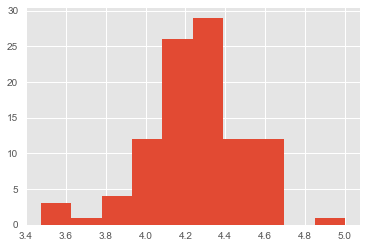

In [34]:
plt.hist(ids_results)

# Objective $f_{34}$ 

# Submodularita $f_{34}$ - důkaz

In [25]:
rules_all_set = set(range(len(list_of_rules)))
initial_solution = set(random.sample(rules_all_set, 4))

marginal_increase_dict = {
    "set_intersect" : [],
    "mean" : [],
    "simple_sum": []
}
objective_func = {
    "set_intersect" : [],
    "mean" : [],
    "simple_sum": []   
}

f_34s = [
    f_34_modified_set_intersect,
    f_34_modified_cover_mean,
    f_34_modified_simple_sum
]

labels = [
    "set_intersect",
    "mean",
    "simple_sum",
]

for i in range(10):
    new_rule = random.sample(rules_all_set - initial_solution, 1)[0]
    
    
    for i, func_34 in enumerate(f_34s):
        init_sol_tmp = copy.copy(initial_solution)
        
        
        func_val_before = func_34(list(init_sol_tmp), list_of_rules, df)
        init_sol_tmp.add(new_rule)
        
        func_val_now = func_34(list(init_sol_tmp), list_of_rules, df)
    
        marginal_increase = func_val_now - func_val_before
    
        marginal_increase_dict[labels[i]].append(marginal_increase)
        objective_func[labels[i]].append(func_val_now)
        
    
    initial_solution.add(new_rule)
    
    

In [26]:
f34_df_marginal = pd.DataFrame(marginal_increase_dict)

f34_df_marginal

,mean,set_intersect,simple_sum
0,0.450000,0,53
1,-0.366667,1,49
2,0.166667,0,52
3,-0.250000,0,49
4,0.027778,0,51
5,-0.177778,0,49
6,-0.145455,0,49
7,-0.121212,0,49
8,-0.256410,0,47
9,0.208791,0,53


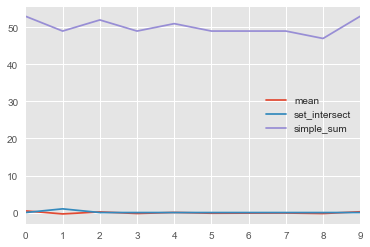

In [27]:
f34_df_marginal.plot()

In [28]:
f34_df_objective = pd.DataFrame(objective_func)

f34_df_objective

,mean,set_intersect,simple_sum
0,51.200000,131,256
1,50.833333,132,305
2,51.000000,132,357
3,50.750000,132,406
4,50.777778,132,457
5,50.600000,132,506
6,50.454545,132,555
7,50.333333,132,604
8,50.076923,132,651
9,50.285714,132,704


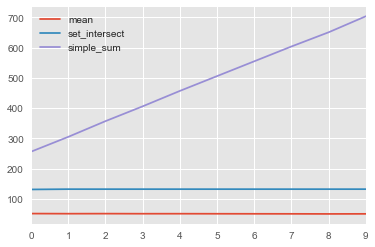

In [29]:
f34_df_objective.plot()

# Default rule testing

In [31]:
_, soln_ = run_IDS()

new_Y = Y
default_class(soln_, list_of_rules, df, Y, new_Y, method="major_class_remaining")

2/n*n OPT value is 547.1234567901234
Estimating omega for rule 0
Standard Error 127.07266031684392
Estimating omega for rule 1
Standard Error 85.53831889860824
Estimating omega for rule 2
Standard Error 95.9127989373681
Estimating omega for rule 3
Standard Error 107.59608264244568
Estimating omega for rule 4
Standard Error 166.4757670052912
Estimating omega for rule 5
Standard Error 129.47192745919867
Estimating omega for rule 6
Standard Error 121.42046367890381
Estimating omega for rule 7
Standard Error 109.62144407003585
Estimating omega for rule 8
Standard Error 111.64372351368436
Estimating omega for rule 9
Standard Error 109.69188666442017
Estimating omega for rule 10
Standard Error 103.95428322103903
Estimating omega for rule 11
Standard Error 144.50974015615694
Estimating omega for rule 12
Standard Error 109.66014772924574
Estimating omega for rule 13
Standard Error 126.41710722841272
Estimating omega for rule 14
Standard Error 129.7320816143794
Estimating omega for rule 15
Stan

'Iris-versicolor'

In [32]:
default_class(soln_, list_of_rules, df, Y, new_Y, method="major_class")

'Iris-versicolor'